# The version of the 2-FAST notebook in which I (hopefully) don't insert stupid bugs
(And the interpolator should also be better)

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using TwoFAST
using Dierckx
using DelimitedFiles
using QuadOsc
using FunctionZeros
using TwoFAST

Precompiling FastChebInterp
  ✓ StaticArrays → StaticArraysChainRulesCoreExt
  ✓ FastChebInterp
  2 dependencies successfully precompiled in 2 seconds. 23 already precompiled.
Precompiling LoopVectorization
  ✓ StaticArrayInterface → StaticArrayInterfaceOffsetArraysExt
  ✓ CloseOpenIntervals
  ✓ LayoutPointers
  ✓ VectorizationBase
  ✓ SLEEFPirates
  ✓ LoopVectorization
  6 dependencies successfully precompiled in 17 seconds. 40 already precompiled.
Precompiling SpecialFunctionsExt
  ✓ LoopVectorization → SpecialFunctionsExt
  1 dependency successfully precompiled in 2 seconds. 66 already precompiled.
Precompiling Interpolations
  ✓ Interpolations
  1 dependency successfully precompiled in 2 seconds. 25 already precompiled.


In [3]:
using Revise
using Will

Precompiling Will
  ✓ Will
  1 dependency successfully precompiled in 8 seconds. 254 already precompiled.


### Interpolating N5K stuff

In [4]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
# THAT'S THE NEW INTERPOLATION SCHEME!!!
y = LinRange(log10(first(k)),
log10(last(k)), length(k))


x = LinRange(first(z), last(z),
length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
power_spectrum(k, χ1, χ2) = sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

In [8]:
ℓ = 20

20

### Evaluating Chebyshev coefficients

In [9]:
kmax = 200/13 
kmin = 2.5/7000
nχ = 100
χ = LinRange(26, 7000, nχ)
χ_list = LinRange(26, 7000, 10)

#calculate coefficients of chebychev decomposition
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

### Loading my Ts

In [10]:
function load_Ts(folder)
    ell_vector = npzread("ell_vector.npy") 
    full_T = zeros(26, 100, 100, 129)
    for i in 1:26
        l_string = string(round(ell_vector[i]; digits=1))
        filename = folder * "/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

load_Ts (generic function with 1 method)

In [11]:
T_CC = load_Ts("T_tilde_CC")
T_CL = load_Ts("T_tilde_CL")
T_LL = load_Ts("T_tilde_LL")

w_CC = Will.w_ell_tullio(coeff, T_CC)
w_CL = Will.w_ell_tullio(coeff, T_CL)
w_LL = Will.w_ell_tullio(coeff, T_LL);

In [12]:
function calc_qosc(χ_list, label, ℓ, fix, power_spectrum)

    if label == "LL"
        idx = -2
    elseif label == "CL"
        idx = 0 
    elseif label == "CC"
        idx = 2
    end
    
    result_Ia = zeros(length(χ_list))
    #result_Ib = zeros(length(χ_list))
    

    if fix == false
        @time for i in 1:10
            println("Processing QuadOsc for χ = $(χ_list[i])")
            Ia, Ea = quadosc(x->power_spectrum(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            #Ib, Eb = quadosc(x->power_spectrum(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            
            result_Ia[i] = Ia
            #result_Ib[i] = Ib
            
        end
    elseif fix == true
        fix_chi = χ_list[7]
        @time for i in 1:10
            println("Processing QuadOsc for χ = $(χ_list[i])")
            Ia, Ea = quadosc(x->power_spectrum(x, fix_chi,fix_chi)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            #Ib, Eb = quadosc(x->power_spectrum(x, fix_chi,fix_chi)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ_list[i])
            
            result_Ia[i] = Ia
            #result_Ib[i] = Ib
            
        end
    end

    return result_Ia#, result_Ib
end

calc_qosc (generic function with 1 method)

In [13]:
function calc_pad(χ_list, label, ℓ, fix, power_spectrum)
    result_pquad = zeros(length(χ_list))
    fix_chi = χ_list[7]
    
    if label == "LL"
        idx = -2
    elseif label == "CL"
        idx = 0 
    elseif label == "CC"
        idx = 2
    end

    if fix == false
        @time for i in 1:10
            println("Processing p-quad for χ = $(χ_list[i])")
            pquad = Cubature.pquadrature(x->power_spectrum(x, χ_list[i], χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmin, 2*kmax;
                                  reltol=sqrt(1e-12), abstol=0, maxevals=2^19)[1]
        
            result_pquad[i] = pquad 
        end
    elseif fix == true
        @time for i in 1:10
            println("Processing p-quad for χ = $(χ_list[i])")
            pquad = Cubature.pquadrature(x->power_spectrum(x, fix_chi, fix_chi)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)^2 *(x^idx), kmin, 2*kmax;
                                  reltol=sqrt(1e-12), abstol=0, maxevals=2^19)[1]
        
            result_pquad[i] = pquad
        end
    end
    return result_pquad
end
        

calc_pad (generic function with 1 method)

# Let's start by matching quadosc and p-adaptive diagonals

### LL

In [22]:
result_Ia_LL = calc_qosc(χ_list, "LL", ℓ, false, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
  0.086211 seconds (679.99 k allocations: 79.727 MiB)


In [23]:
result_pquad_LL = calc_pad(χ_list, "LL", ℓ, false, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  0.207296 seconds (3.76 M allocations: 57.340 MiB)


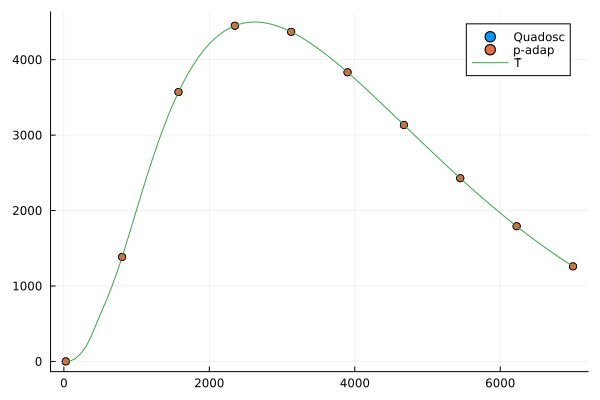

In [24]:
#scatter(χ_list, result_Ia_LL .- result_Ib_LL, label = "Quadosc")
scatter(χ_list, result_Ia_LL, label = "Quadosc")
scatter!(χ_list, result_pquad_LL, label = "p-adap")
plot!(χ, diag(w_LL[22,:,:]), label="T̃")

    Okay good, now let's try that 2-FAST bitch ass code

In [25]:
function build_2FAST_chi_evolution(chi_array, label, ℓ)
    w_2F = zeros(length(chi_array))
    N = 4096
    chi0 = 0.001
    kmax = 1e4
    kmin = 4e-5 
    ell = [Int(ℓ)] 
    RR = [1.0]

    if label == "LL"
        q = -2.1
        idx = 4
        N = 30000
        kmin = 1e-5
        kmax = 1e7
        chi0 = 0.00001
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end

    # calculate M_ll at high ell, result gets saved to a file:
    f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
    write("out/F21EllCache", f21cache)

    # calculate all M_ll, result gets saved to a file:
    mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
    write("out/MlCache", mlcache)

    for i in 1:length(chi_array)
        println("Processing χ = $(chi_array[i])")
        # calculate wljj:
        w00 = Array{Float64}(undef, N, length(RR))
        function outfunc(wjj, ell, rr, RR)
            w00[:,:] = wjj[1]
        end
        rr = calcwljj(x->power_spectrum(x, chi_array[i], chi_array[i])/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
        interp= Spline1D(rr, w00[:,1])
        w00_interp = interp.(chi_array)*π/2
        
        w_2F[i] = w00_interp[i]
    end
    return w_2F
end        

build_2FAST_chi_evolution (generic function with 1 method)

In [26]:
w_2F_LL = build_2FAST_chi_evolution(χ_list, "LL", ℓ);

  q=-2.1, R=1.0:	  0.007728 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = -2.1
kmin = 1.0e-5
kmax = 1.0e7
χ0 = 1.0e-5
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e7
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006497 seconds (182 allocations: 638.156 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[8.895543050869093e-29 + 0.0im, 0.0 + 0.0im]
ell 22, elapsed: 3.0040740966796875e-5
ell 21, elapsed: 0.28878211975097656
ell 20, elapsed: 0.004133939743041992
ell 19, elapsed: 0.001065969467163086
ell 18, elapsed: 0.0010669231414794922
  0.320962 seconds (454.89 k allocations: 30.462 MiB, 98.29% compilation time)
elapsed: 0.0018568038940429688
step:          0.090144 sec (107.509 k allocations: 7.59 MB, 0.0% gc time)
swapping:      6.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.024857 sec (6

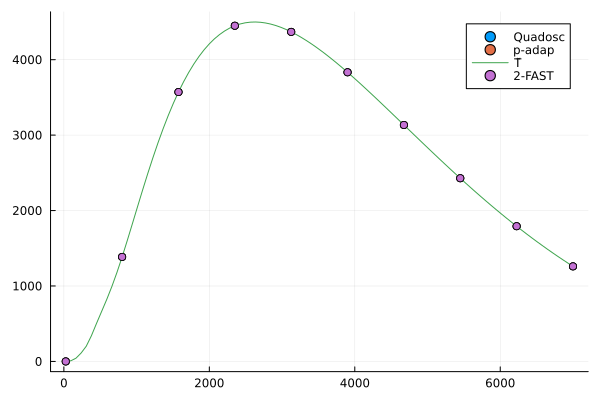

In [27]:
#scatter(χ_list, result_Ia_LL .- result_Ib_LL, label = "Quadosc")
scatter(χ_list, result_Ia_LL, label = "Quadosc")
scatter!(χ_list, result_pquad_LL, label = "p-adap")
plot!(χ, diag(w_LL[22,:,:]), label="T̃")
scatter!(χ_list, w_2F_LL, label="2-FAST")

### CL

In [28]:
result_Ia_CL = calc_qosc(χ_list, "CL", ℓ, false, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
  0.752224 seconds (2.84 M allocations: 2.038 GiB, 26.24% gc time)


In [29]:
result_pquad_CL = calc_pad(χ_list, "CL", ℓ, false, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  0.414919 seconds (8.43 M allocations: 128.599 MiB)


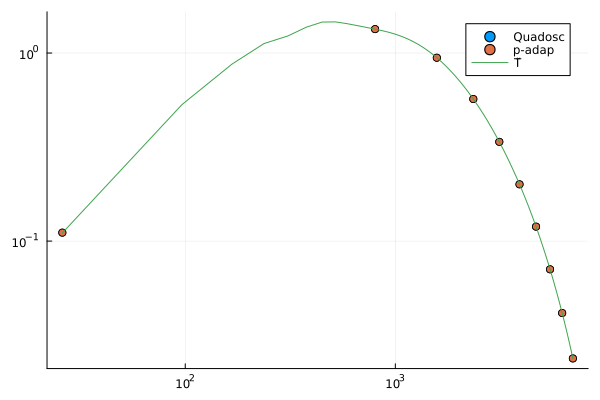

In [30]:
#scatter(χ_list, result_Ia_CL .- result_Ib_CL, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CL, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter!(χ_list, result_pquad_CL, label = "p-adap")
plot!(χ, diag(w_CL[22,:,:]), label="T̃")

In [31]:
w_2F_CL = build_2FAST_chi_evolution(χ_list, "CL", ℓ);

  q=0.5, R=1.0:	  0.002993 seconds (8.20 k allocations: 576.281 KiB)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 4096
q = 0.5
kmin = 4.0e-5
kmax = 10000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 4.0e-5
kmax = 10000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 131136 bytes = 0.0001221299171447754 GiB
Output size: 131136 bytes = 0.0001221299171447754 GiB
Reading 'out/F21EllCache'...   0.012141 seconds (180 allocations: 132.086 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[-1.8713268322904144 + 2.291714415323012e-16im, 0.0 + 0.0im]
ell 22, elapsed: 4.792213439941406e-5
ell 21, elapsed: 0.00025582313537597656
ell 20, elapsed: 0.00012803077697753906
ell 19, elapsed: 0.0006020069122314453
ell 18, elapsed: 0.0005919933319091797
  0.003074 seconds (338 allocations: 17.742 KiB)
elapsed: 0.0009319782257080078
step:          0.000242 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      4.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 6.6e-5 sec (0 allocations: 0 byt

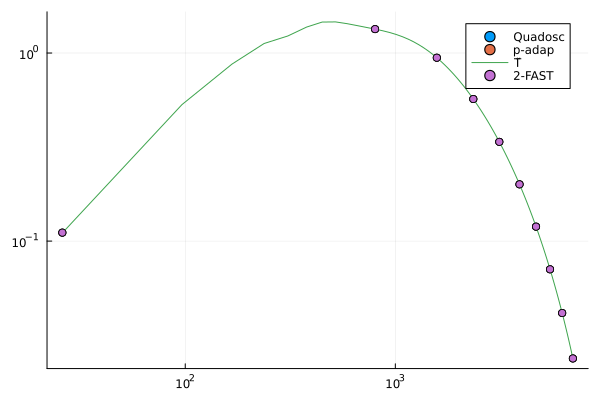

In [33]:
#scatter(χ_list, result_Ia_CL .- result_Ib_CL, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CL, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter!(χ_list, result_pquad_CL, label = "p-adap")
plot!(χ, diag(w_CL[22,:,:]), label="T̃")
scatter!(χ_list, w_2F_CL, label="2-FAST")

### CC

In [64]:
result_Ia_CC = calc_qosc(χ_list, "CC", ℓ, false, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
 41.792412 seconds (33.61 M allocations: 168.222 GiB, 23.65% gc time)


In [35]:
result_pquad_CC = calc_pad(χ_list, "CC", ℓ, false, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  1.182416 seconds (26.79 M allocations: 408.879 MiB)


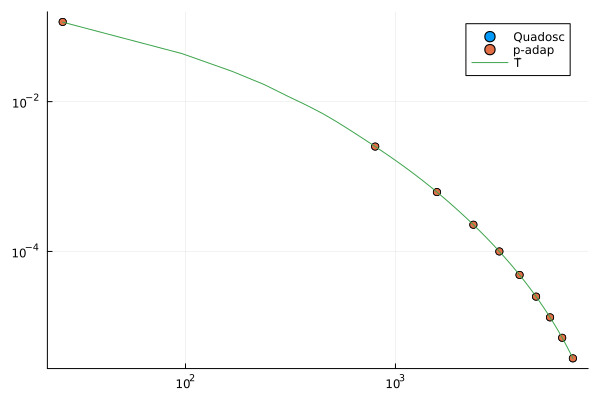

In [36]:
#scatter(χ_list, result_Ia_CC .- result_Ib_CC, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CC, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter!(χ_list, result_pquad_CC, label = "p-adap")
plot!(χ, diag(w_CC[22,:,:]), label="T̃")

In [37]:
w_2F_CC = build_2FAST_chi_evolution(χ_list, "CC", ℓ);

  q=1.1, R=1.0:	  0.005096 seconds (8.20 k allocations: 576.281 KiB)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 4096
q = 1.1
kmin = 4.0e-5
kmax = 10000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 4.0e-5
kmax = 10000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 131136 bytes = 0.0001221299171447754 GiB
Output size: 131136 bytes = 0.0001221299171447754 GiB
Reading 'out/F21EllCache'...   0.010012 seconds (180 allocations: 132.086 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[199657.34004872115 - 4.8901944483388205e-11im, 0.0 + 0.0im]
ell 22, elapsed: 2.384185791015625e-5
ell 21, elapsed: 0.00015211105346679688
ell 20, elapsed: 5.793571472167969e-5
ell 19, elapsed: 0.00018095970153808594
ell 18, elapsed: 0.00018405914306640625
  0.001153 seconds (338 allocations: 17.742 KiB)
elapsed: 0.00033402442932128906
step:          7.7e-5 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 3.0e-5 sec (0 allocations: 0 byte

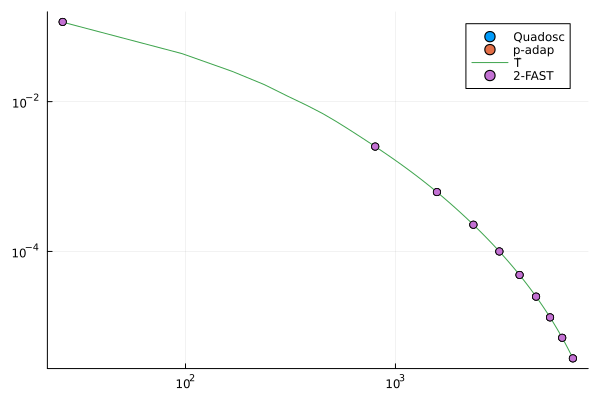

In [39]:
#scatter(χ_list, result_Ia_CC .- result_Ib_CC, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CC, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter!(χ_list, result_pquad_CC, label = "p-adap")
plot!(χ, diag(w_CC[22,:,:]), label="T̃")
scatter!(χ_list, w_2F_CC, label="2-FAST")

# Doing everything without a $\chi$ evolution

In [40]:
coeff2 = zeros(nχ,nχ,n_cheb+1)
fix_chi = χ_list[7]
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,fix_chi, fix_chi), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff2[i,j,:] = c.coefs
        coeff2[j,i,:] = coeff2[i,j,:]
    end
end

In [41]:
w_CC2 = Will.w_ell_tullio(coeff2, T_CC)
w_CL2 = Will.w_ell_tullio(coeff2, T_CL)
w_LL2 = Will.w_ell_tullio(coeff2, T_LL);

### LL

In [42]:
result_Ia_LL2 = calc_qosc(χ_list, "LL",  ℓ, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
  0.270847 seconds (781.69 k allocations: 98.473 MiB, 69.64% compilation time)


In [43]:
result_pquad_LL2 = calc_pad(χ_list, "LL", ℓ, true, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  0.289450 seconds (3.84 M allocations: 62.928 MiB, 42.24% compilation time)


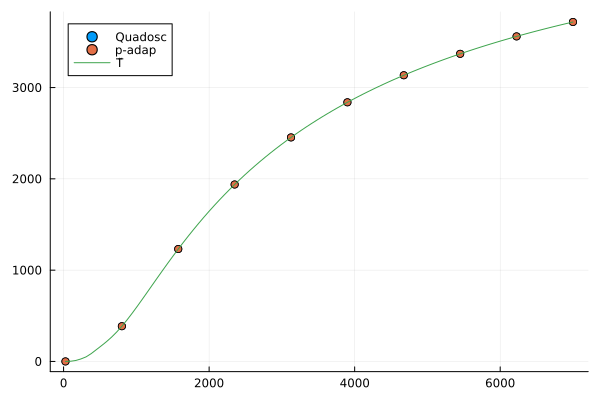

In [65]:
#scatter(χ_list, result_Ia_LL2 .- result_Ib_LL2, label = "Quadosc")
scatter(χ_list, result_Ia_LL2, label = "Quadosc")
scatter!(χ_list, result_pquad_LL2, label = "p-adap")
plot!(χ, diag(w_LL2[22,:,:]), label="T̃")

In [45]:
N = 30000
chi0 = 0.00001
kmax = 1e6 #200/13 
kmin = 1e-5 #2.5/7000
q = -2.5
ell = [Int(ℓ)] 
RR = [1.0]

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00_LL = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    w00_LL[:,:] = wjj[1]
end

rr = calcwljj(x->power_spectrum(x, fix_chi, fix_chi)/x^4, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  q=-2.5, R=1.0:	  0.009936 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = -2.5
kmin = 1.0e-5
kmax = 1.0e6
χ0 = 1.0e-5
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e6
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006219 seconds (180 allocations: 638.031 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[3.291406808148791e-33 + 0.0im, 0.0 + 0.0im]
ell 22, elapsed: 3.886222839355469e-5
ell 21, elapsed: 0.0008678436279296875
ell 20, elapsed: 0.00032401084899902344
ell 19, elapsed: 0.0012531280517578125
ell 18, elapsed: 0.001260995864868164
  0.005755 seconds (338 allocations: 17.742 KiB)
elapsed: 0.0016260147094726562
step:          0.000411 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      7.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000286 sec (0 allocations: 0 byte, 0.0% gc time)


In [46]:
interp= Spline1D(rr, w00_LL[:,1])
w00_LL_interp = interp.(χ)*π/2;

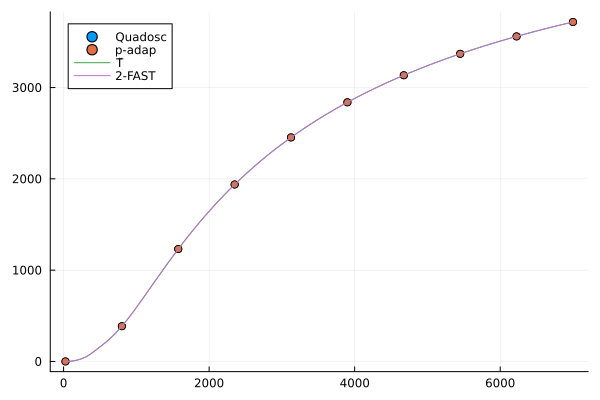

In [49]:
scatter(χ_list, result_Ia_LL2, label = "Quadosc")
scatter!(χ_list, result_pquad_LL2, label = "p-adap")
plot!(χ, diag(w_LL2[22,:,:]), label="T̃")
plot!(χ, w00_LL_interp, label="2-FAST")

### CL

In [50]:
#result_Ia_CL2, result_Ib_CL2  = calc_qosc(χ_list, "CL", ℓ, true, power_spectrum);
result_Ia_CL2  = calc_qosc(χ_list, "CL", ℓ, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
  0.685671 seconds (2.59 M allocations: 1.732 GiB, 30.21% gc time)


In [51]:
result_pquad_CL2 = calc_pad(χ_list, "CL", ℓ, true, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  8.823712 seconds (189.27 M allocations: 2.820 GiB, 2.21% gc time)


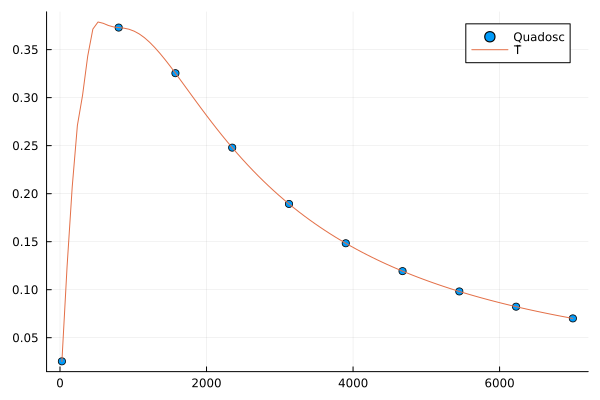

In [53]:
#scatter(χ_list, result_Ia_CL2 .- result_Ib_CL2, label = "Quadosc")
scatter(χ_list, result_Ia_CL2 , label = "Quadosc")
#scatter!(χ_list, result_pquad_CL2, label = "p-adap")
plot!(χ, diag(w_CL2[22,:,:]), label="T̃")

In [54]:
q = 0.5

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00_CL = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    w00_CL[:,:] = wjj[1]
end

rr = calcwljj(x->power_spectrum(x, fix_chi, fix_chi)/x^2, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  q=0.5, R=1.0:	  0.020608 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 0.5
kmin = 1.0e-5
kmax = 1.0e6
χ0 = 1.0e-5
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e6
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006082 seconds (180 allocations: 638.023 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[-37.426536645808284 + 4.583428830646023e-15im, 0.0 + 0.0im]
ell 22, elapsed: 2.4080276489257812e-5
ell 21, elapsed: 0.0005269050598144531
ell 20, elapsed: 0.0003821849822998047
ell 19, elapsed: 0.0014729499816894531
ell 18, elapsed: 0.0012459754943847656
  0.005490 seconds (338 allocations: 17.742 KiB)
elapsed: 0.0015749931335449219
step:          0.000458 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      3.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000158 sec (0 allocations: 0 byte,

In [55]:
interp= Spline1D(rr, w00_CL[:,1])
w00_CL_interp = interp.(χ)*π/2;

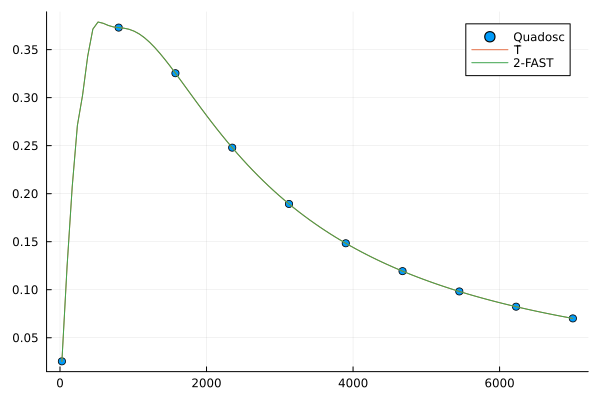

In [56]:
#scatter(χ_list, result_Ia_CL2 .- result_Ib_CL2, label = "Quadosc")
scatter(χ_list, result_Ia_CL2, label = "Quadosc")
#scatter!(χ_list, result_pquad_CL2, label = "p-adap")
plot!(χ, diag(w_CL2[22,:,:]), label="T̃")
plot!(χ, w00_CL_interp, label="2-FAST")

### CC

In [57]:
#result_Ia_CC2, result_Ib_CC2 = calc_qosc(χ_list, "CC", ℓ, true, power_spectrum)
result_Ia_CC2 = calc_qosc(χ_list, "CC", ℓ, true, power_spectrum);

Processing QuadOsc for χ = 26.0
Processing QuadOsc for χ = 800.8888888888888
Processing QuadOsc for χ = 1575.7777777777776
Processing QuadOsc for χ = 2350.6666666666665
Processing QuadOsc for χ = 3125.555555555555
Processing QuadOsc for χ = 3900.444444444445
Processing QuadOsc for χ = 4675.333333333333
Processing QuadOsc for χ = 5450.222222222222
Processing QuadOsc for χ = 6225.11111111111
Processing QuadOsc for χ = 7000.0
 56.385265 seconds (42.09 M allocations: 228.978 GiB, 23.27% gc time)


In [58]:
result_pquad_CC2 = calc_pad(χ_list, "CC", ℓ, true, power_spectrum);

Processing p-quad for χ = 26.0
Processing p-quad for χ = 800.8888888888888
Processing p-quad for χ = 1575.7777777777776
Processing p-quad for χ = 2350.6666666666665
Processing p-quad for χ = 3125.555555555555
Processing p-quad for χ = 3900.444444444445
Processing p-quad for χ = 4675.333333333333
Processing p-quad for χ = 5450.222222222222
Processing p-quad for χ = 6225.11111111111
Processing p-quad for χ = 7000.0
  9.218650 seconds (199.23 M allocations: 2.969 GiB, 2.18% gc time)


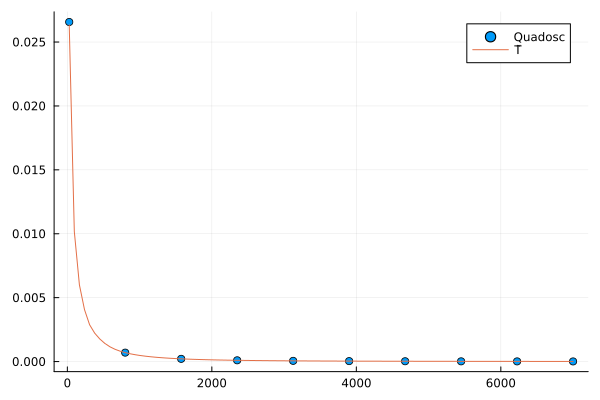

In [59]:
#scatter(χ_list, result_Ia_CC2 .- result_Ib_CC2, label = "Quadosc")
scatter(χ_list, result_Ia_CC2, label = "Quadosc")
#scatter!(χ_list, result_pquad_CC2, label = "p-adap")
plot!(χ, diag(w_CC2[22,:,:]), label="T̃")

In [60]:
q = 1.1
ell = [Int(ℓ)] 

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00_CC = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    w00_CC[:,:] = wjj[1]
end

rr = calcwljj(x->power_spectrum(x, fix_chi, fix_chi), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  q=1.1, R=1.0:	  0.008038 seconds (60.00 k allocations: 4.120 MiB)

ℓ = 20
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 1.1
kmin = 1.0e-5
kmax = 1.0e6
χ0 = 1.0e-5
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-5
kmax = 1.0e6
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.005061 seconds (180 allocations: 638.023 KiB)
ellmax: 22
lmaxcache: 20
fell[:,1,1] = ComplexF64[1.453956024656429e8 - 3.561165183393012e-8im, 0.0 + 0.0im]
ell 22, elapsed: 2.09808349609375e-5
ell 21, elapsed: 0.0003211498260498047
ell 20, elapsed: 0.000247955322265625
ell 19, elapsed: 0.0010750293731689453
ell 18, elapsed: 0.001024007797241211
  0.004274 seconds (338 allocations: 17.742 KiB)
elapsed: 0.0013959407806396484
step:          0.000369 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      2.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000105 sec (0 allocations: 0 byte, 0.0%

In [61]:
interp= Spline1D(rr, w00_CC[:,1])
w00_CC_interp = interp.(χ)*π/2;

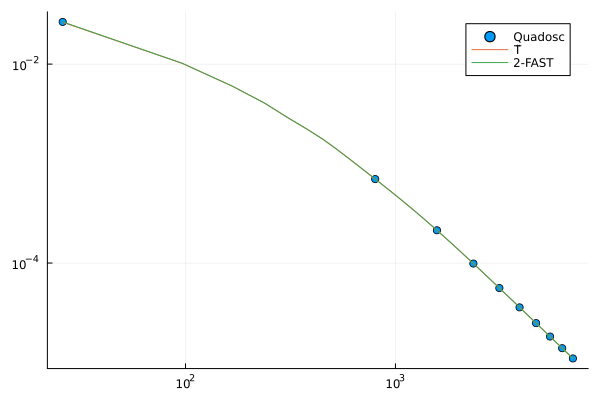

In [63]:
#scatter(χ_list, result_Ia_CC2 .- result_Ib_CC2, label = "Quadosc",xscale=:log10, yscale=:log10)
scatter(χ_list, result_Ia_CC2, label = "Quadosc",xscale=:log10, yscale=:log10)
#scatter!(χ_list, result_pquad_CC2, label = "p-adap")
plot!(χ, diag(w_CC2[22,:,:]), label="T̃")
plot!(χ, w00_CC_interp, label="2-FAST")

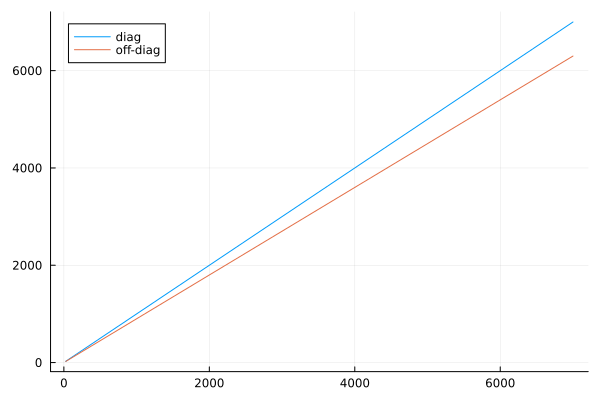

In [75]:
plot(χ,χ, label="diag")
plot!(χ, χ*0.9, label = "off-diag")

# VALIDATING THE OFF-DIAGONAL TERMS (no $\chi$ dependence in P(k))

In [319]:
ℓ = 200.0
lidx = 25
χ_fixed = 3000.0 
RR = 0.5;

In [320]:
coeff3 = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ_fixed, χ_fixed), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff3[i,j,:] = c.coefs
        coeff3[j,i,:] = coeff3[i,j,:]
    end
end

In [321]:
T_CC_v = load_Ts("T_validation/RR_05_CC")
T_CL_v = load_Ts("T_validation/RR_05_CL")
T_LL_v = load_Ts("T_validation/RR_05_LL")

w_CC_v = Will.w_ell_tullio(coeff3, T_CC_v)
w_CL_v = Will.w_ell_tullio(coeff3, T_CL_v)
w_LL_v = Will.w_ell_tullio(coeff3, T_LL_v);

In [322]:
function calculate_2FAST_off_diag(chi_array, label, ℓ, RR, power_spectrum)
    w_2F = zeros(length(chi_array))
    N = 30000
    chi0 = 0.001
    kmax = 1e5
    kmin = 1e-6
    ell = [Int(ℓ)] 
    RR = [RR]

    if label == "LL"
        q = -2.5
        idx = 4
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end

    # calculate M_ll at high ell, result gets saved to a file:
    f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
    write("out/F21EllCache", f21cache)

    # calculate all M_ll, result gets saved to a file:
    mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
    write("out/MlCache", mlcache)

    w00 = Array{Float64}(undef, N, length(RR))
    function outfunc(wjj, ell, rr, RR)
        w00[:,:] = wjj[1]
    end
    rr = calcwljj(x->power_spectrum(x, χ_fixed, χ_fixed)/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
    interp= Spline1D(rr, w00[:,1])
    w00_interp = interp.(chi_array)*π/2
    
    return w00_interp
end;        

In [323]:
function calc_pad_offd(χ_list, label, ℓ, RR, fix, power_spectrum)
    result_pquad = zeros(length(χ_list))
    
    if label == "LL"
        idx = -2
    elseif label == "CL"
        idx = 0 
    elseif label == "CC"
        idx = 2
    end

    if fix == false
        @time for i in 1:10
            println("Processing p-quad for χ = $(χ_list[i])")
            f(x) = power_spectrum(x, χ_list[i], RR*χ_list[i])*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)* Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx)
            pquad = Cubature.pquadrature(x->f(x), kmin, 2*kmax; reltol=sqrt(1e-12), abstol=0, maxevals=2^19)[1]
            result_pquad[i] = pquad 
        end
    elseif fix == true
        @time for i in 1:10
            println("Processing p-quad for χ = $(χ_list[i])")
            f(x) = power_spectrum(x, χ_fixed, χ_fixed)*Bessels.sphericalbesselj(ℓ, χ_list[i]*x)* Bessels.sphericalbesselj(ℓ, RR*χ_list[i]*x) *(x^idx)
            pquad = Cubature.pquadrature(x->f(x), kmin, 2*kmax; reltol=sqrt(1e-12), abstol=0, maxevals=2^19)[1]
            result_pquad[i] = pquad
        end
    end
    return result_pquad
end

calc_pad_offd (generic function with 1 method)

### LL

In [324]:
W_2F_LL_09 = calculate_2FAST_off_diag(χ, "LL", ℓ, RR, power_spectrum);

  q=-2.5, R=0.5:	  0.269411 seconds (1.60 M allocations: 249.860 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = -2.5
kmin = 1.0e-6
kmax = 100000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-6
kmax = 100000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.006433 seconds (180 allocations: 638.031 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[8.255386500509505e-97 + 0.0im, 8.258708790386966e-97 + 0.0im]
ell 202, elapsed: 2.5987625122070312e-5
ell 201, elapsed: 0.000270843505859375
ell 200, elapsed: 0.0003390312194824219
ell 199, elapsed: 0.001104116439819336
ell 198, elapsed: 0.0010561943054199219
  0.004520 seconds (338 allocations: 17.742 KiB)
elapsed: 0.0014348030090332031
step:          0.00038 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      2.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000127 sec (0 alloc

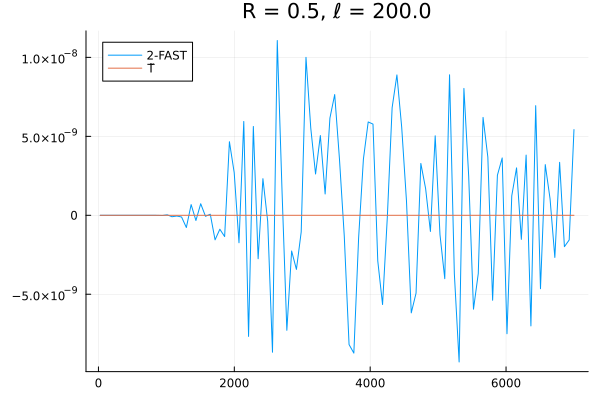

In [325]:
plot(χ, W_2F_LL_09, label="2-FAST", title = "R = $RR, ℓ = $ℓ")
#scatter!(χ_list, result_pquad, label="p-ad")
plot!(χ, diag(w_LL_v[lidx,:,:]), label="T̃")

### CL

In [326]:
W_2F_CL_09 = calculate_2FAST_off_diag(χ, "CL", ℓ, RR, power_spectrum);

  q=0.5, R=0.5:	  0.298220 seconds (1.59 M allocations: 249.594 MiB)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 0.5
kmin = 1.0e-6
kmax = 100000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-6
kmax = 100000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.005540 seconds (180 allocations: 638.023 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[-7.291851827507013e-66 + 8.929943000413239e-82im, -7.312443866122674e-66 + 8.955160974591826e-82im]
ell 202, elapsed: 2.002716064453125e-5
ell 201, elapsed: 0.00032401084899902344
ell 200, elapsed: 0.0002498626708984375
ell 199, elapsed: 0.0010800361633300781
ell 198, elapsed: 0.001051187515258789
  0.004309 seconds (339 allocations: 19.727 KiB)
elapsed: 0.0013849735260009766
step:          0.000376 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time

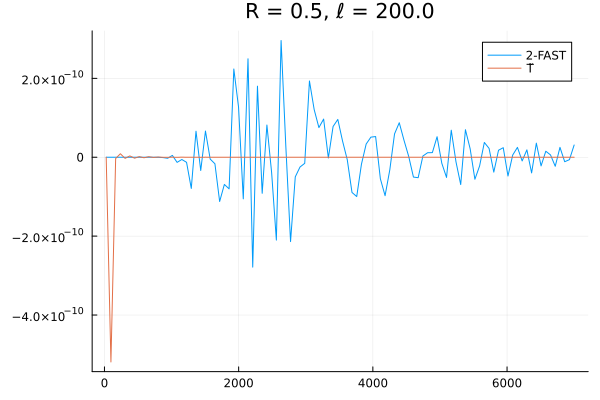

In [327]:
plot(χ, W_2F_CL_09, label="2-FAST", title = "R = $RR, ℓ = $ℓ")
#scatter!(χ_list, w_pad_CL_09, label="p-ad")
plot!(χ, diag(w_CL_v[lidx,:,:]), label="T̃")

### CC

In [328]:
W_2F_CC_09 = calculate_2FAST_off_diag(χ, "CC", ℓ, RR, power_spectrum);

  q=1.1, R=0.5:	  0.362143 seconds (1.59 M allocations: 249.579 MiB, 25.06% gc time)

ℓ = 200
Δℓ = 4
ΔℓRg1 = -4
N = 30000
q = 1.1
kmin = 1.0e-6
kmax = 100000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 1.0e-6
kmax = 100000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 960064 bytes = 0.0008941292762756348 GiB
Output size: 960064 bytes = 0.0008941292762756348 GiB
Reading 'out/F21EllCache'...   0.004755 seconds (180 allocations: 638.023 KiB)
ellmax: 202
lmaxcache: 200
fell[:,1,1] = ComplexF64[3.6581003155370153e-60 - 8.959761684764659e-76im, 3.6702075094522864e-60 - 8.989415757314645e-76im]
ell 202, elapsed: 2.193450927734375e-5
ell 201, elapsed: 0.0002510547637939453
ell 200, elapsed: 0.00023698806762695312
ell 199, elapsed: 0.001074075698852539
ell 198, elapsed: 0.0010509490966796875
  0.004324 seconds (339 allocations: 19.727 KiB)
elapsed: 0.0014958381652832031
step:          0.000366 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 by

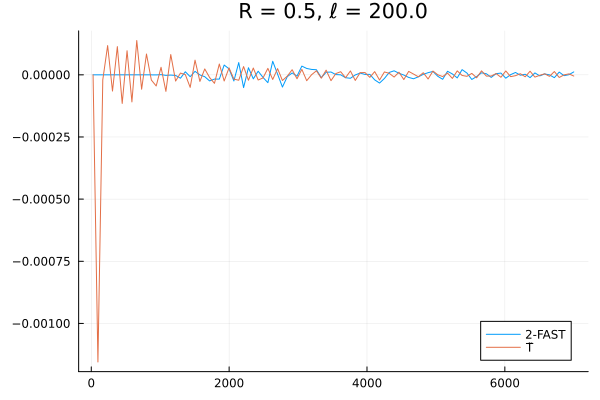

In [329]:
plot(χ, W_2F_CC_09 .*χ .^2, label="2-FAST", title = "R = $RR, ℓ = $ℓ")
#scatter!(χ_list, w_pad_CC_09, label="p-ad")
plot!(χ, diag(w_CC_v[lidx,:,:]).*χ .^2, label="T̃")